# Deploying a Model with Gradio

In [14]:
# load dependencies
import fastbook
fastbook.setup_book()

In [15]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

We can use the duck duck go api to search images -- this allows us to search without an API key.

In [25]:
# preview function
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [29]:
# search for images using a key
ims = search_images_ddg('largemouth bass')
len(images)

200

In [33]:
# save image to folder
dest = 'images/largemouth.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/largemouth.jpg')

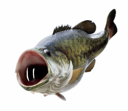

In [35]:
# preview image
im = Image.open(dest)
im.to_thumb(128,128)

In [36]:
# identify labels that we will want to classify fish into
bass_types = 'largemouth', 'smallmouth', 'peacock'
path = Path('bass-types')

In [37]:
# loop through bass types and download images
if not path.exists():
    path.mkdir()
    for bass_type in bass_types:
        dest = (path/bass_type)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{bass_type} bass')
        download_images(dest, urls=results)

In [40]:
# preview folder of image files
im_files = get_image_files(path)
im_files

(#541) [Path('bass-types/largemouth/c095e598-5c1a-4ddb-ae43-d9c0a2883b6e.gif'),Path('bass-types/largemouth/2e0710b2-16f6-44d8-8bd8-043bc634611b.jpg'),Path('bass-types/largemouth/d432d70f-2065-4f57-80d7-975a4a6992a0.jpg'),Path('bass-types/largemouth/a24c37ac-fea7-4fc0-bb4b-c5c1266b1bd2.jpg'),Path('bass-types/largemouth/b13106db-d1ba-42fe-b4a2-e860bda68c93.jpg'),Path('bass-types/largemouth/c27ccdbb-7b95-4258-ac6c-528f51659940.JPG'),Path('bass-types/largemouth/c22f5563-eeed-4c73-9bbe-ddd622580568.jpg'),Path('bass-types/largemouth/e93017e4-4a01-48c9-9269-3529842a7dbe.jpg'),Path('bass-types/largemouth/347582ab-5337-4813-bf02-fd9b527acfd4.jpg'),Path('bass-types/largemouth/a931ac70-a8a1-45ec-b338-9027abedd233.jpg')...]

In [41]:
# check for corrupt files
corrupt_ims = verify_images(im_files)
corrupt_ims

(#13) [Path('bass-types/largemouth/4924b2f7-6628-433a-9604-b73f31cbb8f0.jpg'),Path('bass-types/largemouth/b7a94c86-5937-442b-a19e-7d9b55f9fa9b.jpg'),Path('bass-types/largemouth/c50ed55a-07d3-491d-b6e9-ffcde2e8fe0d.jpg'),Path('bass-types/largemouth/72de0f55-1cf7-4022-822d-2368a465c844.jpg'),Path('bass-types/peacock/bd4255ed-75a9-416f-82dc-10d3806c811d.jpg'),Path('bass-types/peacock/8d80f952-0ae8-415f-b484-bac3d3c585bc.jpg'),Path('bass-types/peacock/40eff741-191e-49ed-a43f-e166f898e0b8.jpg'),Path('bass-types/peacock/fd14cbf8-e278-4742-a300-01d481ebd537.jpg'),Path('bass-types/smallmouth/e3b187a3-5fac-4602-9bd6-e52204628b57.jpg'),Path('bass-types/smallmouth/8f967a80-a80a-4135-ba66-f3ea69081d83.jpg')...]

In [42]:
# see how many failed
len(corrupt_ims)

13

In [43]:
# remove failed images
corrupt_ims.map(Path.unlink);

## Create a DataBlock

In [44]:
# data block
bass = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [45]:
# create our dataloader from our datablock
dls = bass.dataloaders(path)

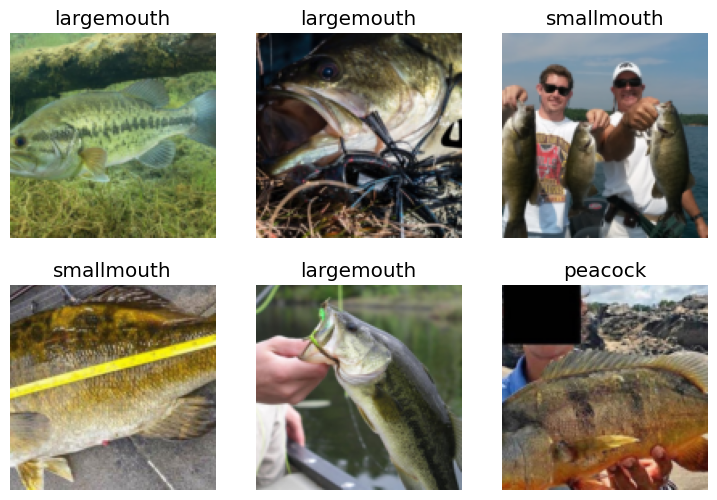

In [47]:
# show batch of images
dls.valid.show_batch(max_n=6, nrows=2)

We can see that by default, fastai has cropped our images, and as a result we lose some detail. 

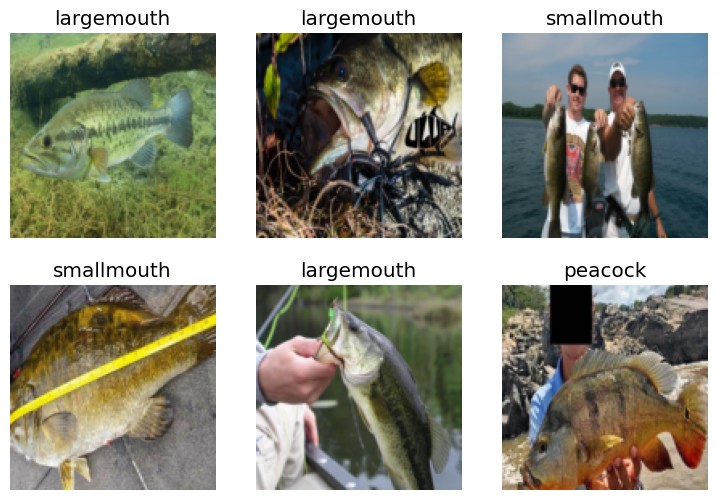

In [48]:
# instead of cropping, squish the images
bass = bass.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bass.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)

We can see that we are no longer losing as much detail, but the images are looking funky now. 

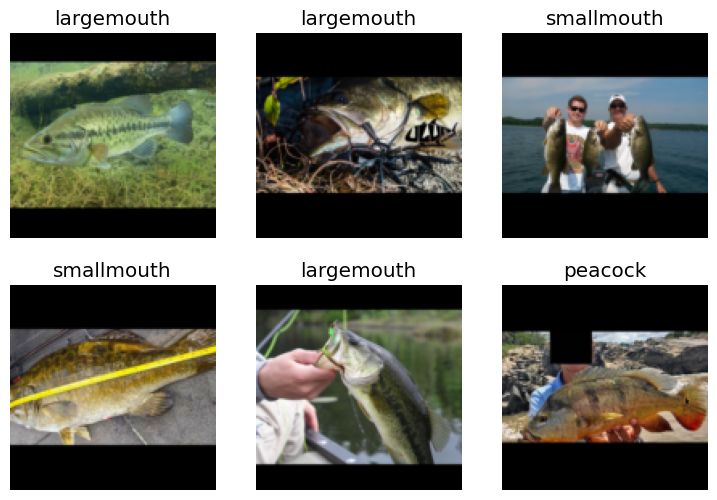

In [49]:
# examine padding instead of squishing
bass = bass.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bass.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)

## Using Random Resize Crop

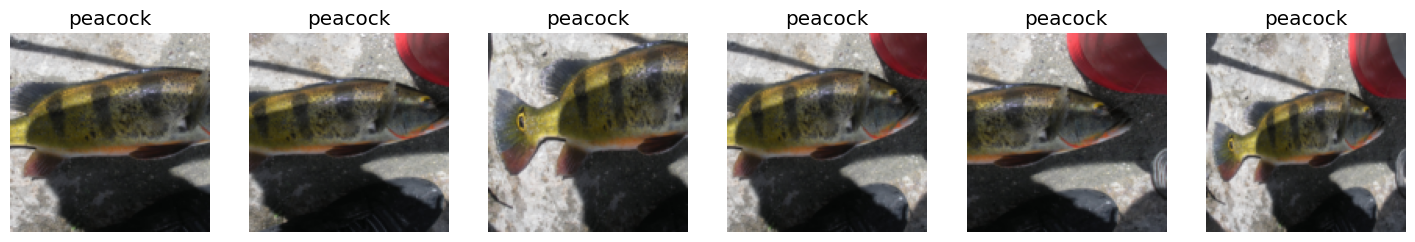

In [50]:
bass = bass.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bass.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=1, unique=True)

## Using Data Augmentation

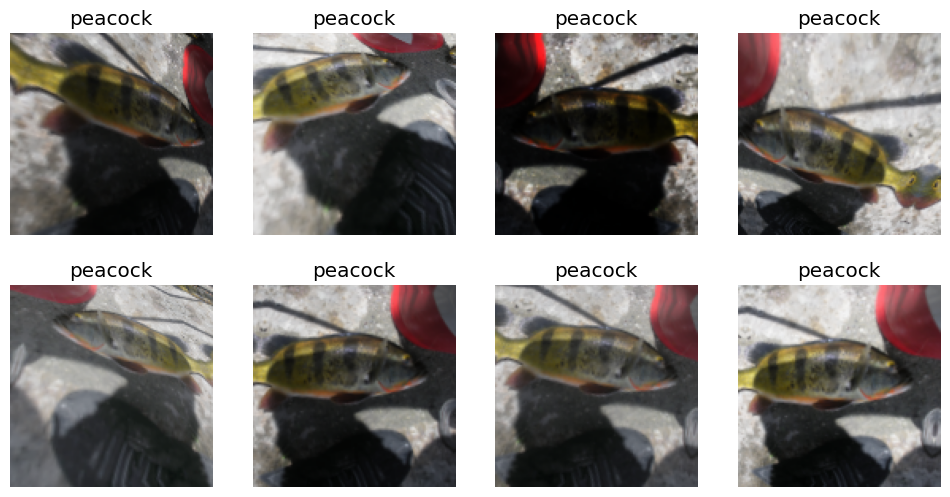

In [53]:
bass = bass.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) # multiplying by 2 to show augmentations easily
dls = bass.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training and Cleaning Data

In [55]:
# specify our data loader
bass = bass.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = bass.dataloaders(path)

In [56]:
# create a learner -- transfer learn with renet18
learn = vision_learner(dls, resnet18, metrics=error_rate)

# train for 4 epochs
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.848948,0.768808,0.266667,00:09
1,0.783367,0.849415,0.228571,00:09
2,0.672087,0.907016,0.200000,00:10
3,0.579958,0.904672,0.209524,00:09


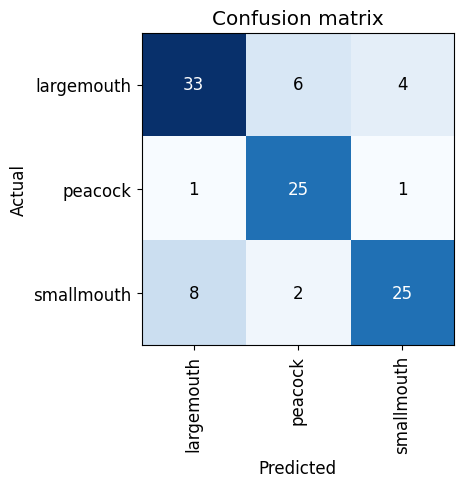

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Examine images with top losses

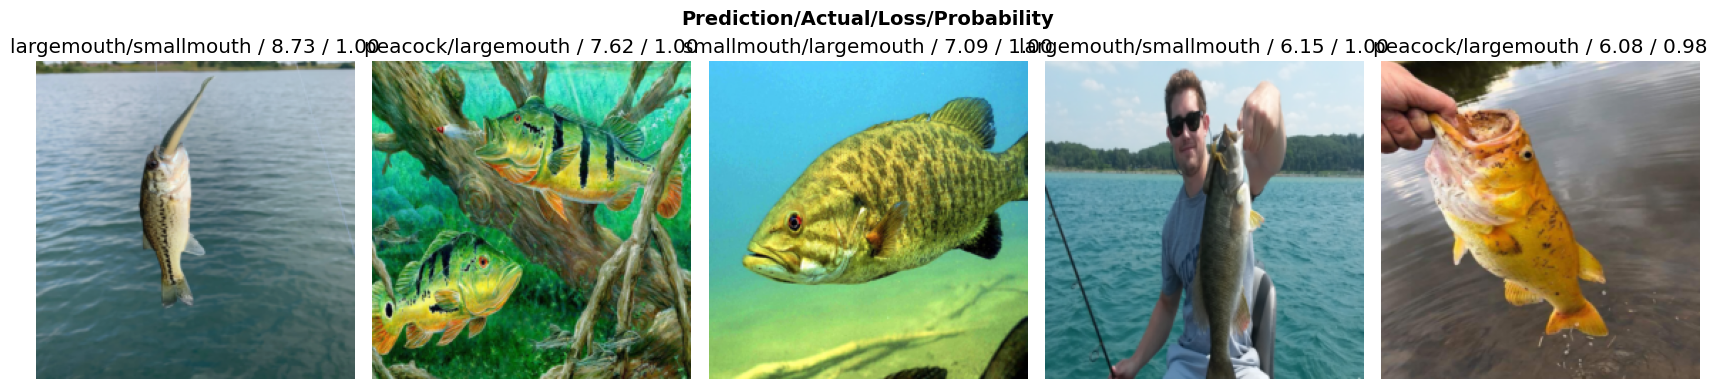

In [59]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))
plt.tight_layout()

We can see that some images are mislabeled which has led to larger loss. If the label was correct and the prediction matched, it may have higher loss due to lower confidence

## Run Image Cleaner

In [61]:
cleaner = ImageClassifierCleaner(learn)
cleaner